# XGBOOST + LIGHTGBM

In [201]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plot
import seaborn as sns
#import training dataset
train_data_2016 = pd.read_csv('data/train_2016.csv', parse_dates=["transactiondate"])
properties_data_2016 = pd.read_csv('data/properties_2016.csv',low_memory=False)
train_data_2017 = pd.read_csv('data/train_2017.csv', parse_dates=["transactiondate"])
properties_data_2017 = pd.read_csv('data/properties_2017.csv',low_memory=False)

## Merge the Dataset 

In [202]:

merged_train_data_2016 = pd.merge(train_data_2016,properties_data_2016,on="parcelid",how="left")
merged_train_data_2017 = pd.merge(train_data_2017,properties_data_2017,on="parcelid",how="left")

merged_train_data = pd.concat([merged_train_data_2016,merged_train_data_2017]).sort_index(kind='merge')


## Total Missing values

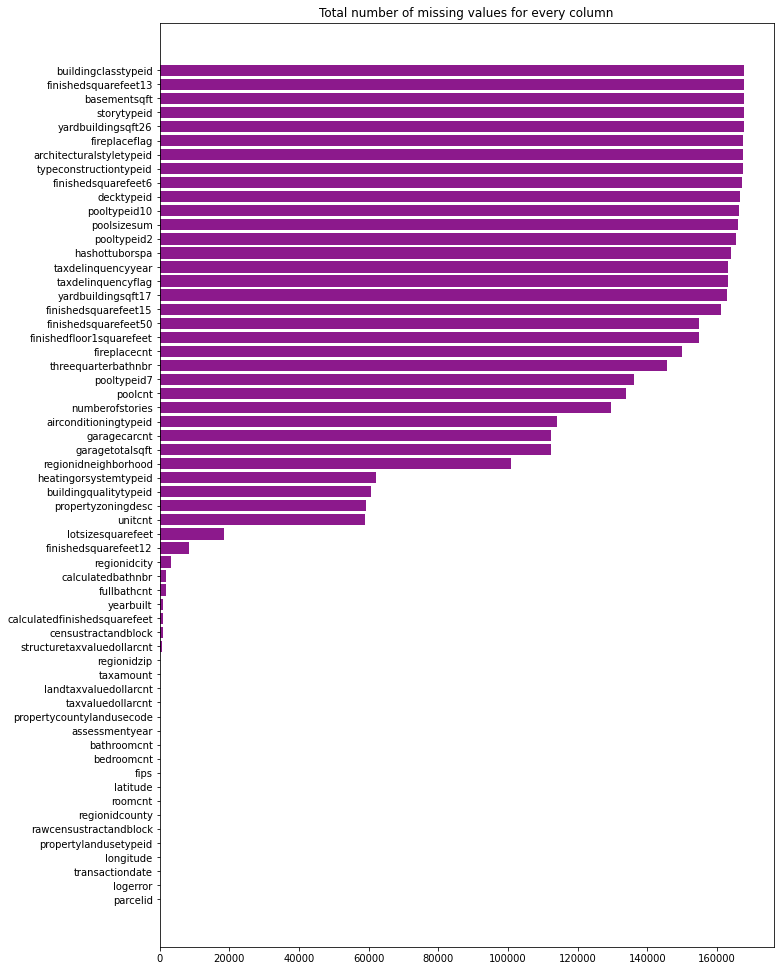

In [203]:
import matplotlib.pyplot as plot

missing_data = merged_train_data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['names', 'counts']
missing_data = missing_data.sort_values(by='counts')

fig, axes = plot.subplots(figsize=(11,17))
axes.barh(np.arange(missing_data.shape[0]), missing_data.counts.values, alpha=0.9,color='purple')
axes.set_title("Total number of missing values for every column")
axes.set_yticks(np.arange(missing_data.shape[0]))
axes.set_yticklabels(missing_data.names.values, rotation='horizontal')
plot.show()

#print(missing_data.names.values)

## Non-numerical data

In [204]:
data_type = merged_train_data.dtypes.reset_index()
data_type.columns = ["Count", "Data Type"]
data_type.groupby("Data Type").aggregate('count').reset_index()

,Data Type,Count
0,int64,1
1,float64,53
2,datetime64[ns],1
3,object,5


In [205]:
data_type.loc[data_type['Data Type'] == 'object']

,Count,Data Type
24,hashottuborspa,object
34,propertycountylandusecode,object
36,propertyzoningdesc,object
51,fireplaceflag,object
57,taxdelinquencyflag,object


## Fill out missing values

In [206]:
merged_data_means = merged_train_data.mean(axis=0)
merged_train_data = merged_train_data.fillna(merged_data_means)
merged_train_data = merged_train_data.fillna(-999.0)
merged_train_data.head(1)

C:\Users\tomzt\AppData\Local\Temp\ipykernel_21108\3640561800.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  merged_data_means = merged_train_data.mean(axis=0)
C:\Users\tomzt\AppData\Local\Temp\ipykernel_21108\3640561800.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  merged_data_means = merged_train_data.mean(axis=0)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,7.299145,695.376344,2.0,3.0,3.967742,4.0,...,1.437764,1.0,122754.0,360170.0,2015.0,237416.0,6735.88,-999.0,13.827247,6.037107e+13


## Data with non-numeric value

In [207]:
#use LabelEncoder to deal with non numerical data 
for feature in merged_train_data.columns:
    if merged_train_data[feature].dtype=='object':
        label = preprocessing.LabelEncoder()
        label.fit(list(merged_train_data[feature].values)) 
        merged_train_data[feature] = label.transform(list(merged_train_data[feature].values))
merged_train_data.head(1)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,7.299145,695.376344,2.0,3.0,3.967742,4.0,...,1.437764,0,122754.0,360170.0,2015.0,237416.0,6735.88,0,13.827247,6.037107e+13


In [208]:
merged_train_data['transactiondate'] = pd.to_datetime(merged_train_data['transactiondate'])  
mask = (merged_train_data['transactiondate'] > '2016-12-01') & (merged_train_data['transactiondate'] <= '2016-12-30')
data = merged_train_data.loc[mask]
data.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
3421,13923841,0.0090,2016-12-28,13.000000,7.299145,695.376344,2.5,2.0,3.967742,6.015461,...,1.000000,0,128318.0,355334.0,2015.0,227016.0,4382.96,0,13.827247,6.059086e+13
10829,10736972,-0.0367,2016-12-14,1.000000,7.299145,695.376344,4.0,6.0,3.967742,4.000000,...,1.437764,0,278410.0,352441.0,2015.0,74031.0,4415.55,0,13.827247,6.037800e+13
10941,11663348,0.0751,2016-12-05,1.000000,7.299145,695.376344,3.0,3.0,3.967742,1.000000,...,1.437764,0,345355.0,1148212.0,2015.0,802857.0,13961.06,0,13.827247,6.037263e+13
12731,11913710,0.1621,2016-12-13,1.814345,7.299145,695.376344,4.0,5.0,3.967742,4.000000,...,1.437764,0,272354.0,697495.0,2015.0,425141.0,9522.84,0,13.827247,6.037480e+13
14707,11061551,0.0421,2016-12-20,1.000000,7.299145,695.376344,2.0,3.0,3.967742,4.000000,...,1.437764,0,142831.0,223602.0,2015.0,80771.0,2932.39,0,13.827247,6.037117e+13


## Explore log error and eliminate outliers

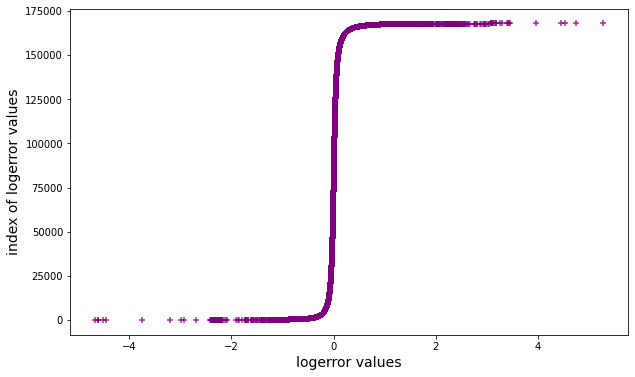

In [209]:
import numpy as np 
import matplotlib.pyplot as plot
import seaborn as sns

plot.figure(figsize=(10,6))
x, y = pd.Series(np.sort(merged_train_data.logerror.values), name="logerror values"), pd.Series(range(merged_train_data.shape[0]), name="index of logerror values")
sns.regplot(x=x, y=y, marker="+",fit_reg=False,color='purple')
plot.xlabel('logerror values', fontsize=14)
plot.ylabel('index of logerror values', fontsize=14)
plot.show()
merge_train_data = merged_train_data[merged_train_data.logerror > -1.7]
merge_train_data = merged_train_data[merged_train_data.logerror < 1.7]

# Feature Selection


## Feature Importance

[14:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




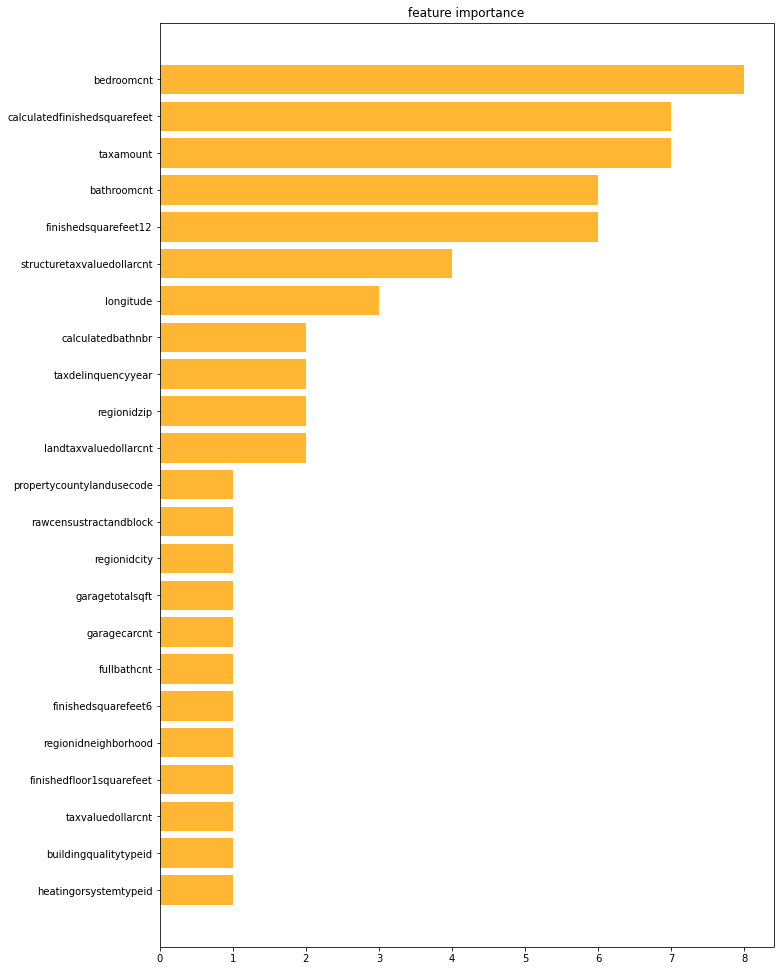

In [210]:
from sklearn import preprocessing
import xgboost as xgb

feature_Importance_data = merged_train_data

        
y = feature_Importance_data.logerror.values
X = feature_Importance_data.drop(["parcelid", "transactiondate", "logerror"], axis=1)
params = {'eta': 0.05,'max_depth': 3,'subsample': 0.4,'colsample_bytree': 0.4,'objective': 'reg:linear','eval_metric': 'mae',
'silent': 1}
plst = list(params.items())
dtrain = xgb.DMatrix(X, y, feature_names=X.columns.values, missing=-999.0)
xgb1 = xgb.train(plst, dtrain, num_boost_round=10)

feaImport = xgb1.get_fscore()
feas = pd.DataFrame()
feas['features'] = feaImport.keys()
feas['importance'] = feaImport.values()

#display feature importance graph
feas = feas.sort_values(by='importance')
fig, axes = plot.subplots(figsize=(11,17))
axes.barh(np.arange(feas.shape[0]), feas.importance.values, alpha=0.8,color='orange')
axes.set_title("feature importance")
axes.set_yticks(np.arange(feas.shape[0]))
axes.set_yticklabels(feas.features.values, rotation='horizontal')
plot.show()

The result from this part can be combined with the result from feature coefficient analysis to help me to do feature selection for traning the model.

## train and test split

In [212]:
from sklearn.model_selection import train_test_split
import gc


dftrain = merged_train_data.drop(['architecturalstyletypeid','basementsqft','buildingclasstypeid','decktypeid','finishedsquarefeet13','finishedsquarefeet15',
                 'finishedsquarefeet6','hashottuborspa','poolsizesum','pooltypeid10','pooltypeid2','storytypeid',
                 'typeconstructiontypeid','yardbuildingsqft17','yardbuildingsqft26','fireplaceflag','taxdelinquencyflag',
                       'taxdelinquencyyear','parcelid','logerror','transactiondate','airconditioningtypeid','buildingqualitytypeid','calculatedbathnbr',
                       'finishedfloor1squarefeet','finishedsquarefeet50','fips','fireplacecnt','fullbathcnt','garagecarcnt','garagetotalsqft','heatingorsystemtypeid',
                       'latitude','longitude','censustractandblock','landtaxvaluedollarcnt','assessmentyear','taxvaluedollarcnt','numberofstories','unitcnt',
                      'threequarterbathnbr','unitcnt','threequarterbathnbr','roomcnt','regionidzip','regionidneighborhood','lotsizesquarefeet','poolcnt','pooltypeid7','propertycountylandusecode'
                      ,'propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty'], axis=1)
dftrain.head(1)
x_train, x_test, y_train, y_test = train_test_split(dftrain, merged_train_data['logerror'].values, test_size=0.33)
del dftrain; gc.collect()

13618

In [213]:
x_train.head(1)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,finishedsquarefeet12,yearbuilt,structuretaxvaluedollarcnt,taxamount
37544,3.0,4.0,2996.0,2996.0,1999.0,282906.0,5994.96


## HyperParameter Tunning with Grid Search and Cross Validation

In [211]:
def tune_model(model, params, X, y):
    gs = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_absolute_error',  cv=5, refit=False)
    gs.fit(X, y)
    return gs.best_params, gs.best_score_

## Implementation of LightGBM

In [214]:
#Try Cross validate with 80000, 70000, and 75000 split

import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold


ps = {}
ps['min_data'] = 500
ps['objective'] = 'regression'
ps['learning_rate'] = 0.001
ps['min_hessian'] = 1
ps['sub_feature'] = 0.5
ps['boosting_type'] = 'gbdt'
ps['num_leaves'] = 200
ps['metric'] = 'mae'

split = 75000
xtrain, ytrain, xvalid, yvalid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]
print('train shape: {}\ncross validate Shape : {}'.format(xtrain.shape, xvalid.shape))
dtrain = lgb.Dataset(xtrain, label=ytrain)
dvalid = lgb.Dataset(xvalid, label=yvalid)


print( "\nTraining LightGBM ...")
model = lgb.LGBMRegressor(min_data = 500, objective='regression', learning_rate=0.001, 
                          min_hessian=1,sub_feature=0.5,boosting_type='gbdt',
                     num_leaves=200,metric='mae')
lgb_model = model.fit(xtrain,ytrain)
#lgb_model = lgb.train(ps, dtrain, 700, [dvalid])



train shape: (75000, 7)
cross validate Shape : (37484, 7)

Training LightGBM ...
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, will be overridden by min_hessian=1. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.5. Current value: feature_fraction=0.5


## Predict and get MAE 

In [215]:
#Predict and get MAE
lgb_pred = lgb_model.predict(x_test)
mean_absolute_error(y_test, lgb_pred)

0.06984312466163152

## R-square 

In [216]:
from sklearn.metrics import r2_score
train_r2 = r2_score(y_true=y_test, y_pred=lgb_pred)
print(train_r2)

0.0007416983906730623


Low R square: it may be data related issue, the variance between training and testing data

## Implementation of XGBoosting 

In [217]:
#Implementation and Tuning
# Xgb Tuning
# 0.069794492038748074
# max depth 6->8
# 0.069945733399468635

# Max depth 6->5  5->4 worse
# 0.069713735740486213

# Boosting round
# 150->180
# 0.069627739666462143

# 180->200
# Worse

# 180-190
# Worse

# 180-170
# 0.069625408699950306

# 170-160
# 0.069623370406690657
from xgboost.sklearn import XGBRegressor
import xgboost as xgb


x_train_xgb = x_train
y_train_xgb = y_train
y_mean = y_train_xgb.mean(axis=0)



print( "\nTraining XGBoost ...")
model = XGBRegressor(n_estimators = 160, max_depth=5, eta=0.037, eval_metric='mae',alpha=0.4,reg_lambda=0.8,
                     subsample=0.90,objective='reg:linear',base_score=y_mean,silent=1)
xgb_model=model.fit(x_train_xgb,y_train_xgb)
#xgb_model = xgb.train(dict(xgb_ps, silent=1), d_train_xgb, num_boost_round=num_boost_rounds)


Training XGBoost ...
[14:23:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\house-price-predictor\env1\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## Predict and get MAE

In [218]:

#Predict and get MAE
#dtest = xgb.DMatrix(xtest)
xgb_pred = xgb_model.predict(x_test)
mean_absolute_error(y_test, xgb_pred)

0.07000506510733166

## R-square 

In [219]:
from sklearn.metrics import r2_score
train_r2 = r2_score(y_true=y_test, y_pred=xgb_pred)
print(train_r2)

0.012450106705513386


# Combination of LightGBM+XGBoosting+(NN)

## stacking + r^2 

In [220]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
stacking_model = StackingRegressor([
    ("xgboost", xgb_model), 
    ("lightgbm", lgb_model),
    
],
    final_estimator=LinearRegression()
)
R2=stacking_model.fit(X=x_train_xgb, y=y_train_xgb).score(x_test,y_test)
print(R2)
stacker = stacking_model.final_estimator_
stacker.intercept_, stacker.coef_

c:\house-price-predictor\env1\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, will be overridden by min_hessian=1. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature

c:\house-price-predictor\env1\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\house-price-predictor\env1\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:32:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\house-price-predictor\env1\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:32:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\house-price-predictor\env1\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:33:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\house-price-predictor\env1\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:33:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, will be overridden by min_hessian=1. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature

c:\house-price-predictor\env1\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.012103783612189556


(-0.0509170098138351, array([0.56536876, 4.15111984]))

## Predict and get MAE

In [221]:

stack_pred=stacking_model.predict(x_test)

mean_absolute_error(y_test, stack_pred)

c:\house-price-predictor\env1\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.06983147271924423

## Saving the model for api

In [226]:
import pickle
filename = 'XGB&GBM.pkl'
pickle.dump(model, open(filename, 'wb'))

## predicted vs actual log error

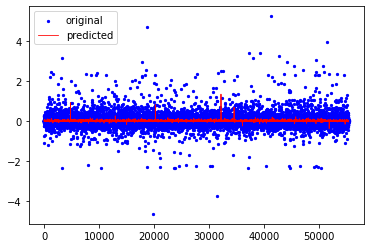

In [223]:
x_ax = range(len(y_test))
plot.scatter(x_ax, y_test, s=5, color="blue", label="original")
plot.plot(x_ax, stack_pred, lw=0.8, color="red", label="predicted")
plot.legend()
plot.show()